# Import Packages

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib 
import os
import shutil
import cv2

In [2]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Downloading and preparing the dataset:

In [2]:
import opendatasets as op

In [4]:
import opendatasets as op
op.download("https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database")

100%|██████████| 778M/778M [00:33<00:00, 24.3MB/s]


In [3]:
dataset_folder = "covid19-radiography-database/COVID-19_Radiography_Dataset"

In [6]:
delete_files = [
    "COVID.metadata.xlsx",
    "Lung_Opacity.metadata.xlsx",
    "Normal.metadata.xlsx",
    "README.md.txt",
    "Viral Pneumonia.metadata.xlsx"
]
for file_ in delete_files:
  os.remove(os.path.join(dataset_folder, file_))

In [7]:
delete_folders = ["COVID/masks",
                  "Lung_Opacity/masks",
                  "Normal/masks",
                  "Viral Pneumonia/masks"]
for folder in delete_folders:
  shutil.rmtree(os.path.join(dataset_folder, folder), ignore_errors = True)

In [8]:
!wget https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/9xkhgts2s6-4.zip

--2023-01-22 08:04:19--  https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/9xkhgts2s6-4.zip
Resolving prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)... 52.218.36.107, 52.92.18.250, 52.92.18.154, ...
Connecting to prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)|52.218.36.107|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3747510717 (3.5G) [application/zip]
Saving to: ‘9xkhgts2s6-4.zip’

9xkhgts2s6-4.zip    100%[===================>]   3.49G  10.4MB/s    in 6m 29s  

2023-01-22 08:10:49 (9.19 MB/s) - ‘9xkhgts2s6-4.zip’ saved [3747510717/3747510717]



In [ ]:
!unzip 9xkhgts2s6-4.zip

In [4]:
another_dataset = os.path.join("Curated Dataset for COVID-19 Posterior-Anterior Chest Radiography Images (X-Rays)",
                               "Curated X-Ray Dataset",
                               "Curated X-Ray Dataset")

In [11]:
!mkdir final_dataset
!mkdir final_dataset/Normal
!mkdir final_dataset/Covid
!mkdir final_dataset/Pneumonia-Viral
!mkdir final_dataset/Pneumonia-Bacterial
!mkdir final_dataset/Lung_Opacity

In [4]:
final_dataset = "final_dataset"

## Move First dataset to Final Dataset

In [13]:
def move_files(src, dest):
  images = list(pathlib.Path(src).glob("*.*"))
  for image in images:
    shutil.copy(str(image), dest)

In [14]:
move_files(os.path.join(dataset_folder, "Normal/images"),
           os.path.join(final_dataset, "Normal"))

In [15]:
move_files(os.path.join(dataset_folder, "COVID/images/"), 
           os.path.join(final_dataset, "Covid"))

In [16]:
move_files(os.path.join(dataset_folder, "Lung_Opacity/images/"), 
           os.path.join(final_dataset, "Lung_Opacity"))

In [17]:
move_files(os.path.join(dataset_folder, "Viral Pneumonia/images/"), 
           os.path.join(final_dataset, "Pneumonia-Viral"))

## Move Second dataset to Final Dataset

In [18]:
move_files(os.path.join(another_dataset, "COVID-19/"), 
           os.path.join(final_dataset, "Covid"))

In [19]:
move_files(os.path.join(another_dataset, "Normal/"), 
           os.path.join(final_dataset, "Normal"))

In [20]:
move_files(os.path.join(another_dataset, "Pneumonia-Bacterial/"), 
           os.path.join(final_dataset, "Pneumonia-Bacterial"))

In [21]:
move_files(os.path.join(another_dataset, "Pneumonia-Viral/"), 
           os.path.join(final_dataset, "Pneumonia-Viral"))

In [5]:
dataset = pathlib.Path(final_dataset)

In [7]:
images = []
labels = []
classes = ["Normal", "Covid", "Lung_Opacity", "Pneumonia-Bacterial", "Pneumonia-Viral"]
index = 0
for cl in classes:
  list_class_images = list(dataset.glob(os.path.join(cl, "*.*")))
  for image in list_class_images:
    img = cv2.imread(str(image), 0)
    img = cv2.resize(img, (64, 64))
    img = img/255
    images.append(img)
    labels.append(index)
  index+=1

In [8]:
images = np.array(images)
labels = np.array(labels)

In [9]:
labels = tf.keras.utils.to_categorical(labels)
labels

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [10]:
labels.shape

(30374, 5)

In [11]:
images.shape

(30374, 64, 64)

## Samples of dataset images

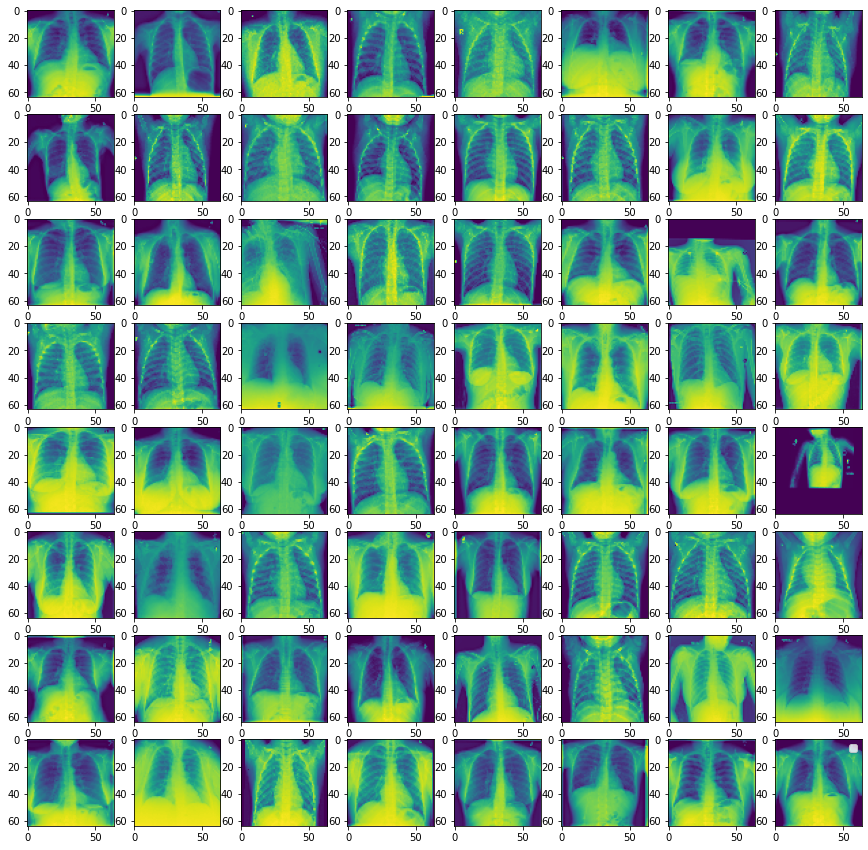

In [12]:
plt.figure(figsize = (15, 15))
for i in range(64):
  plt.subplot(8, 8, (i + 1))
  plt.imshow(images[i])
plt.legend()

# Conditional Variational Autoencoders

In [13]:
import keras.backend as K

In [14]:
def sampling(args):
  z_mean, z_log_v = args
  batch = tf.shape(z_mean)[0]
  dims = tf.shape(z_mean)[1]
  e = K.random_normal(shape = (batch, dims))
  return z_mean + tf.exp(0.5*z_log_v)*e

In [42]:
latent_space = 1024

In [43]:
cond_input = tf.keras.layers.Input(shape = (5, ))

In [44]:
def res_block(inputs, filters, strides = 1):
  x = tf.keras.layers.Conv2D(filters, 3, padding = "same", strides = strides)(inputs)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation("LeakyReLU")(x)
  return x

In [45]:
encoder_input = tf.keras.layers.Input(shape = (64, 64, 1,))
filters = 16
x = res_block(encoder_input, filters)
for stack in range(5):
  for block in range(3):
    strides = 1
    if stack > 0 and block == 0:
      strides = 2
    y = res_block(x, filters, strides = strides)
    y = tf.keras.layers.Conv2D(filters, 3, padding = "same")(y)
    y = tf.keras.layers.BatchNormalization()(y)
    if stack > 0 and block == 0:
      x = tf.keras.layers.Conv2D(filters, 1, strides = strides, padding = 'same')(x)
    x = tf.keras.layers.add([x, y])
    x = tf.keras.layers.Activation('LeakyReLU')(x)
  filters*=2
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.concatenate([x, cond_input])
x = tf.keras.layers.BatchNormalization()(x)
z_mean = tf.keras.layers.Dense(latent_space, name = "z_mean")(x)
z_log_v = tf.keras.layers.Dense(latent_space, name = "z_log_v")(x)
z = tf.keras.layers.Lambda(sampling, output_shape = (latent_space, ), 
                           name = "z")([z_mean, z_log_v])
encoder = tf.keras.models.Model(
    inputs = [encoder_input, cond_input],
    outputs = [z_mean ,z_log_v, z]
)

In [46]:
encoder.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d_35 (Conv2D)             (None, 64, 64, 16)   160         ['input_5[0][0]']                
                                                                                                  
 batch_normalization_36 (BatchN  (None, 64, 64, 16)  64          ['conv2d_35[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_39 (Activation)     (None, 64, 64, 16)   0           ['batch_normalization_36[0]

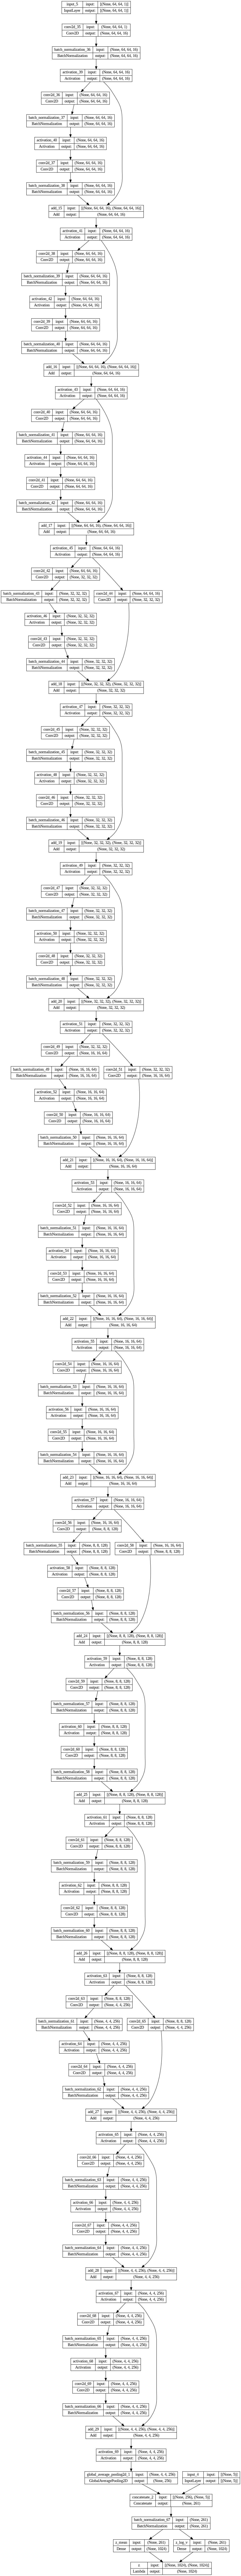

In [47]:
tf.keras.utils.plot_model(encoder, show_shapes = True)

In [61]:
def res_block_Conv2DTranspose(inputs, filters, strides = 1):
  x = tf.keras.layers.Conv2DTranspose(filters, 3, padding = "same", strides = strides)(inputs)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation("LeakyReLU")(x)
  return x

In [66]:
decoder_input = tf.keras.layers.Input(shape = (latent_space,))
filters = 256
x = tf.keras.layers.concatenate([decoder_input, cond_input])
x = tf.keras.layers.Dense(4*4*256)(x)
x = tf.keras.layers.Reshape((4, 4, 256))(x)
for stack in range(5):
  for block in range(3):
    strides = 1
    if stack > 0 and block ==0:
      strides = 2
    y = res_block_Conv2DTranspose(x, filters, strides = strides)
    y = tf.keras.layers.Conv2DTranspose(filters, 3, padding = "same", strides = 1)(y)
    y = tf.keras.layers.BatchNormalization()(y)
    if stack > 0 and block ==0:
      x = tf.keras.layers.Conv2DTranspose(filters, 1, strides = strides, padding = 'same')(x)
    x = tf.keras.layers.average([x, y])
    x = tf.keras.layers.Activation('LeakyReLU')(x)
  filters/=2
output = tf.keras.layers.Conv2DTranspose(1, 3, activation = "sigmoid", padding = "same")(x)
decoder = tf.keras.models.Model(
    inputs = [decoder_input, cond_input],
    outputs = output
)
decoder.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 1024)]       0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 concatenate_9 (Concatenate)    (None, 1029)         0           ['input_12[0][0]',               
                                                                  'input_4[0][0]']                
                                                                                                  
 dense_7 (Dense)                (None, 4096)         4218880     ['concatenate_9[0][0]']    

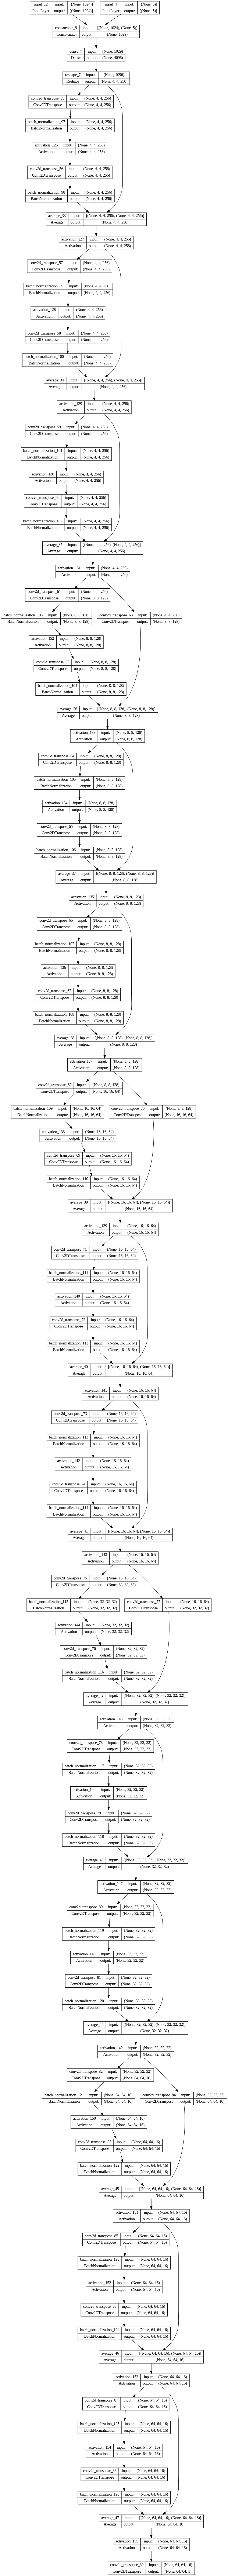

In [67]:
tf.keras.utils.plot_model(decoder, show_shapes = True)

In [68]:
vae_outputs = decoder([encoder([encoder_input, cond_input])[2], cond_input])
vae_model = tf.keras.models.Model(
    inputs = encoder.input,
    outputs = vae_outputs
)
vae_model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 model_3 (Functional)           [(None, 1024),       4919028     ['input_5[0][0]',                
                                 (None, 1024),                    'input_4[0][0]']                
                                 (None, 1024)]                                                    
                                                                                           

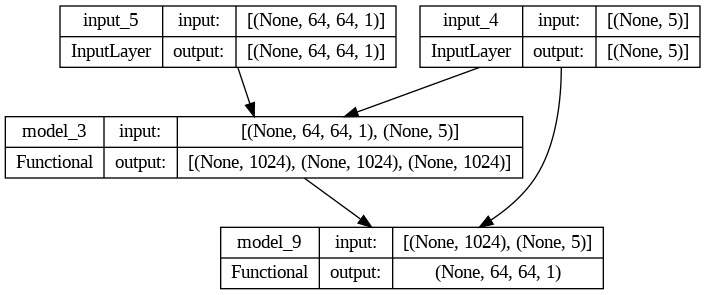

In [69]:
tf.keras.utils.plot_model(vae_model, show_shapes = True)

In [70]:
re_loss = tf.keras.losses.mse(encoder_input, vae_outputs)
batch_re_loss = tf.reduce_mean(re_loss)
re_loss = batch_re_loss*64*64

In [71]:
beta = 1
kl_loss = 1 + z_log_v - tf.exp(z_log_v) - tf.square(z_mean)
kl_loss = tf.reduce_mean(kl_loss)
kl_loss = kl_loss*(-0.5*beta)

In [72]:
kl_loss

<KerasTensor: shape=() dtype=float32 (created by layer 'tf.math.multiply_8')>

In [73]:
final_error = kl_loss + re_loss
final_error

<KerasTensor: shape=() dtype=float32 (created by layer 'tf.__operators__.add_5')>

In [74]:
vae_model.add_loss(final_error)

In [75]:
vae_model.compile(optimizer = "adam")

In [32]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, 
                                                    random_state = True)

In [33]:
x_train.shape, x_test.shape

((24299, 64, 64), (6075, 64, 64))

## Training CVAE

In [76]:
history = vae_model.fit(
    x = [x_train, y_train], y = [x_train, y_train],
    validation_data =  ([x_test, y_test], [x_test, y_test]),
    epochs = 60, 
    batch_size = 64, 
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor = "val_loss", mode = "min", patience = 5, 
                                         restore_best_weights = True)
    ]
)

Epoch 1/60
380/380 [==============================] - 95s 224ms/step - loss: 50.8407 - val_loss: 51.2523
Epoch 2/60
380/380 [==============================] - 83s 218ms/step - loss: 27.3465 - val_loss: 43.6274
Epoch 3/60
380/380 [==============================] - 83s 218ms/step - loss: 23.7345 - val_loss: 37.2518
Epoch 4/60
380/380 [==============================] - 83s 218ms/step - loss: 21.4004 - val_loss: 30.0191
Epoch 5/60
380/380 [==============================] - 83s 217ms/step - loss: 20.4871 - val_loss: 32.1538
Epoch 6/60
380/380 [==============================] - 82s 217ms/step - loss: 19.2967 - val_loss: 32.4058
Epoch 7/60
380/380 [==============================] - 83s 217ms/step - loss: 18.5085 - val_loss: 23.3457
Epoch 8/60
380/380 [==============================] - 83s 217ms/step - loss: 17.9404 - val_loss: 19.4093
Epoch 9/60
380/380 [==============================] - 83s 217ms/step - loss: 17.4604 - val_loss: 17.5968
Epoch 10/60
380/380 [==============================] - 

## The results obtained for (CVAE)

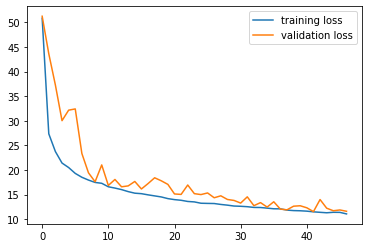

In [77]:
plt.plot(history.history['loss'], label = "training loss")
plt.plot(history.history['val_loss'], label = "validation loss")
plt.legend()

In [90]:
vae_model.evaluate([x_train, y_train], [x_train, y_train])

760/760 [==============================] - 25s 32ms/step - loss: 11.1271


11.127111434936523

In [78]:
vae_model.evaluate([x_test, y_test], [x_test, y_test])

190/190 [==============================] - 6s 33ms/step - loss: 11.5207


11.520659446716309

In [79]:
predict = vae_model.predict([x_test, y_test])

190/190 [==============================] - 6s 21ms/step


In [80]:
predict.shape

(6075, 64, 64, 1)

## Samples of chest x-ray images from the test data

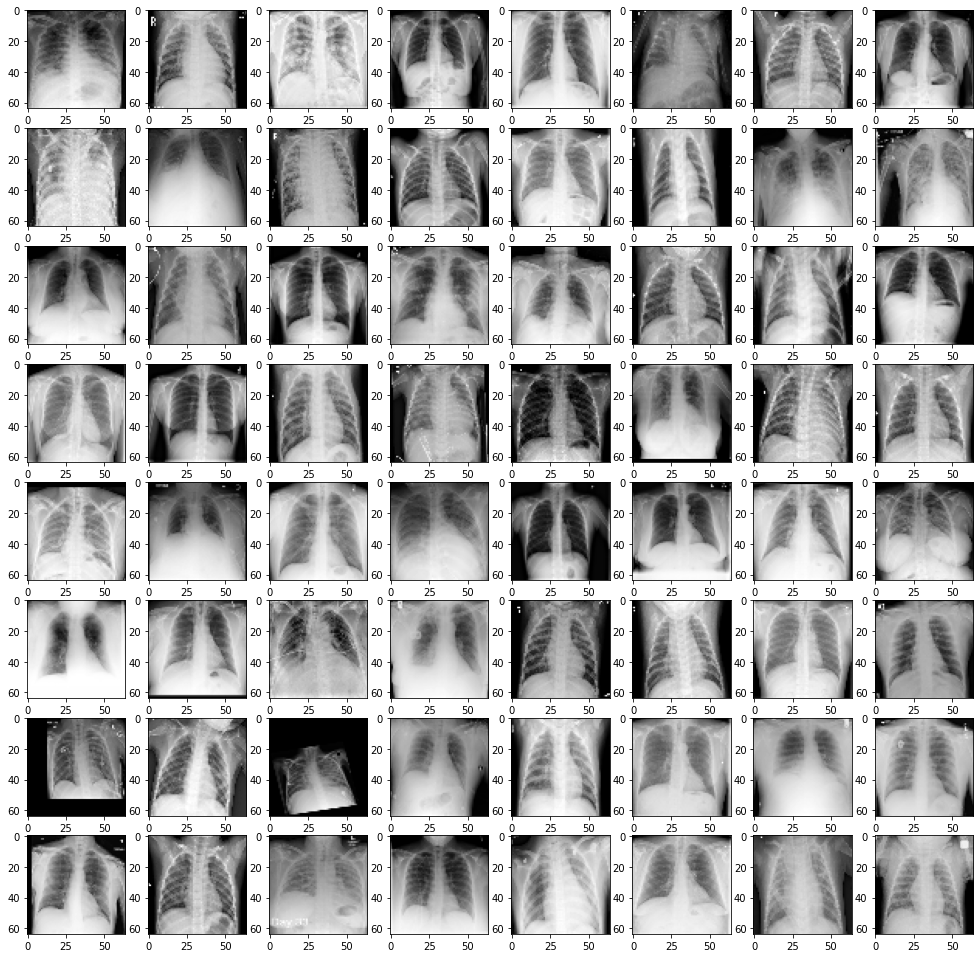

In [84]:
plt.figure(figsize = (17, 17))
for i in range(64):
  plt.subplot(8, 8 ,(i + 1))
  plt.imshow(np.reshape(x_test[i], (64, 64)), cmap='gray')
plt.legend()

## Samples of chest X-ray images from test data after regeneration using (CVAE)

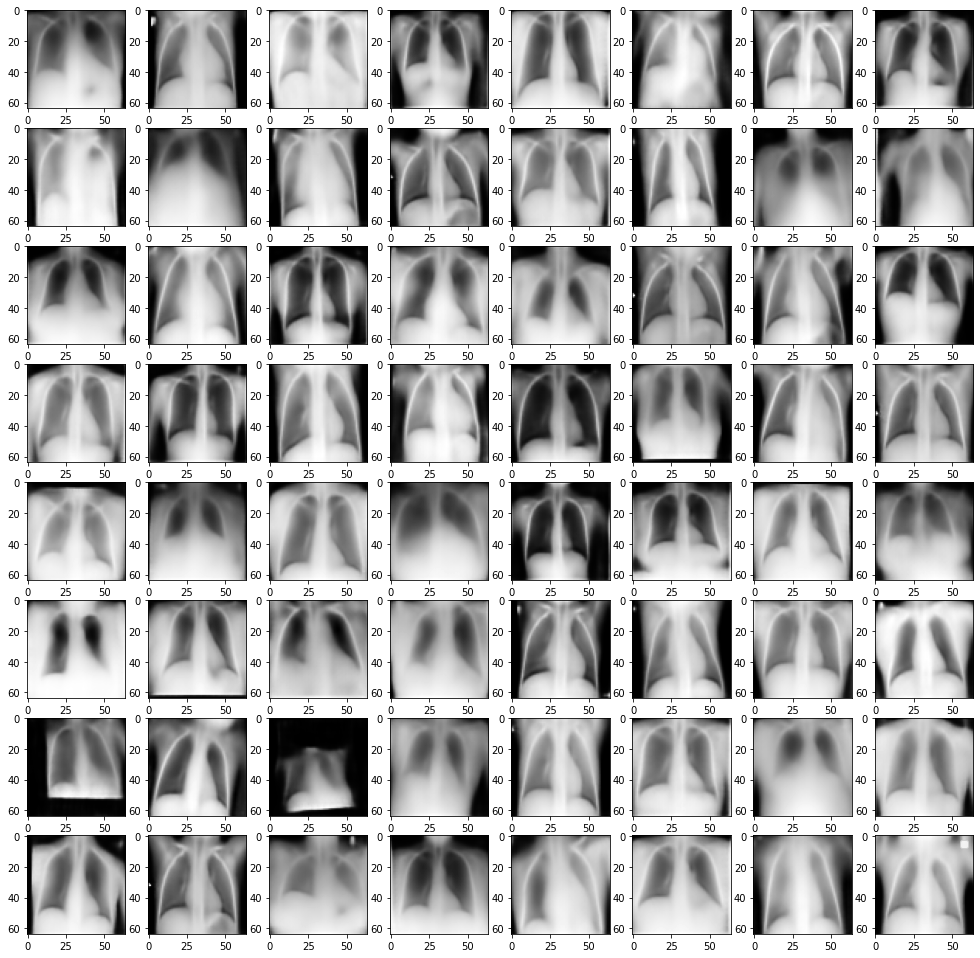

In [85]:
plt.figure(figsize = (17, 17))
for i in range(64):
  plt.subplot(8, 8 ,(i + 1))
  plt.imshow(np.reshape(predict[i], (64, 64)), cmap='gray')
plt.legend()

In [87]:
z_mean, z_log_v, z = encoder.predict([x_train, y_train])

760/760 [==============================] - 8s 10ms/step


# Classification Section
In this part, it was tested that the generated x-ray images contain the most important information, by building a neural network to identify pulmonary diseases, and the images generated from the obstetric network were tested, by reaching a balanced model and high accuracy during Training and testing process.

In [93]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((24299, 64, 64), (6075, 64, 64), (24299, 5), (6075, 5))

In [95]:
np.unique(np.argmax(y_train, axis = 1), return_counts = True)

(array([0, 1, 2, 3, 4]), array([10702,  3927,  4831,  2436,  2403]))

In [96]:
np.unique(np.argmax(y_test, axis = 1), return_counts = True)

(array([0, 1, 2, 3, 4]), array([2761,  970, 1181,  565,  598]))

In [133]:
model =  tf.keras.applications.densenet.DenseNet121(weights = None,
                                                    input_shape = (64, 64, 1),
                                                    include_top = False,
                                                    pooling = 'avg')
x = tf.keras.layers.Dense(512, activation = "relu")(model.output)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.45)(x)
x = tf.keras.layers.Dense(256, activation = "relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.45)(x)
x = tf.keras.layers.Dense(128, activation = "relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.45)(x)
output = tf.keras.layers.Dense(5, activation = "softmax")(x)
m = tf.keras.models.Model(
    inputs = model.input, 
    outputs = output
)

In [134]:
m.summary()

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 zero_padding2d_18 (ZeroPadding  (None, 70, 70, 1)   0           ['input_22[0][0]']               
 2D)                                                                                              
                                                                                                  
 conv1/conv (Conv2D)            (None, 32, 32, 64)   3136        ['zero_padding2d_18[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1/conv[0][0]']      

In [135]:
m.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001), loss = "categorical_crossentropy", metrics = ['accuracy'])

In [107]:
update_x_train = vae_model.predict([x_train, y_train])

760/760 [==============================] - 16s 21ms/step


In [108]:
update_x_test = vae_model.predict([x_test, y_test])

190/190 [==============================] - 4s 22ms/step


In [109]:
update_x_train.shape, update_x_test.shape

((24299, 64, 64, 1), (6075, 64, 64, 1))

In [136]:
history_fit = m.fit(update_x_train, y_train, 
                    validation_data = (update_x_test, y_test),
                    epochs = 120, 
                    batch_size = 32, 
                    callbacks = [
                        tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = "min", 
                                                         patience = 3, restore_best_weights = True)
                    ])

Epoch 1/120
760/760 [==============================] - 55s 60ms/step - loss: 2.1938 - accuracy: 0.3063 - val_loss: 2.4343 - val_accuracy: 0.2663
Epoch 2/120
760/760 [==============================] - 43s 57ms/step - loss: 1.7007 - accuracy: 0.4394 - val_loss: 1.1335 - val_accuracy: 0.6040
Epoch 3/120
760/760 [==============================] - 43s 57ms/step - loss: 1.4674 - accuracy: 0.5108 - val_loss: 0.9659 - val_accuracy: 0.6660
Epoch 4/120
760/760 [==============================] - 43s 57ms/step - loss: 1.3115 - accuracy: 0.5657 - val_loss: 0.8975 - val_accuracy: 0.6974
Epoch 5/120
760/760 [==============================] - 44s 57ms/step - loss: 1.1969 - accuracy: 0.6015 - val_loss: 0.7823 - val_accuracy: 0.7267
Epoch 6/120
760/760 [==============================] - 43s 57ms/step - loss: 1.1285 - accuracy: 0.6228 - val_loss: 0.7165 - val_accuracy: 0.7529
Epoch 7/120
760/760 [==============================] - 44s 57ms/step - loss: 1.0398 - accuracy: 0.6490 - val_loss: 0.6906 - val_ac

## Results of the neural network after training

In [138]:
m.evaluate(update_x_test, y_test, batch_size = 32)

190/190 [==============================] - 3s 16ms/step - loss: 0.4490 - accuracy: 0.8352


[0.4489569664001465, 0.8352263569831848]

In [139]:
m.evaluate(update_x_train, y_train, batch_size = 32)

760/760 [==============================] - 13s 17ms/step - loss: 0.2404 - accuracy: 0.9085


[0.24037832021713257, 0.9084736108779907]

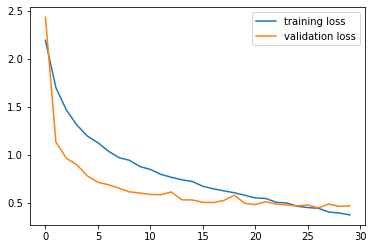

In [140]:
plt.plot(history_fit.history['loss'], label = "training loss")
plt.plot(history_fit.history['val_loss'], label = 'validation loss')
plt.legend()

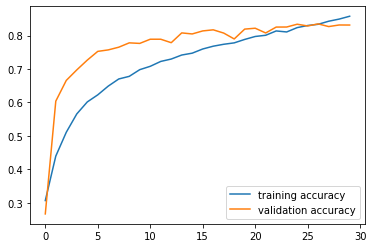

In [141]:
plt.plot(history_fit.history['accuracy'], label = "training accuracy")
plt.plot(history_fit.history['val_accuracy'], label = 'validation accuracy')
plt.legend()

In [142]:
pred = m.predict(update_x_test)

190/190 [==============================] - 4s 15ms/step


In [144]:
pred = np.argmax(pred, axis = 1)

In [145]:
from sklearn.metrics import accuracy_score, classification_report

In [146]:
accuracy_score(pred, np.argmax(y_test, axis = 1))

0.8352263374485597

In [156]:
import seaborn as sns
cm = tf.math.confusion_matrix(np.argmax(y_test, axis = 1), pred)
cm = pd.DataFrame(np.asarray(cm), columns = classes, index = classes)
cm.head(n = 5)

Normal  Covid  Lung_Opacity  Pneumonia-Bacterial  \
Normal                 2503     82           154                    0   
Covid                    50    858            53                    3   
Lung_Opacity            199     89           887                    2   
Pneumonia-Bacterial       6      7             4                  378   
Pneumonia-Viral           8     12             4                  126   

                     Pneumonia-Viral  
Normal                            22  
Covid                              6  
Lung_Opacity                       4  
Pneumonia-Bacterial              170  
Pneumonia-Viral                  448

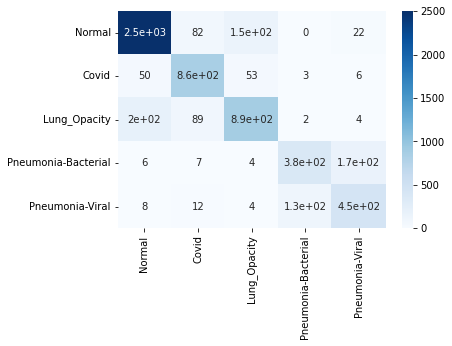

In [160]:
sns.heatmap(cm, annot=True, cmap = 'Blues')

In [147]:
print(classification_report(pred, np.argmax(y_test, axis = 1)))

              precision    recall  f1-score   support

           0       0.91      0.90      0.91      2766
           1       0.88      0.82      0.85      1048
           2       0.75      0.80      0.78      1102
           3       0.67      0.74      0.70       509
           4       0.75      0.69      0.72       650

    accuracy                           0.84      6075
   macro avg       0.79      0.79      0.79      6075
weighted avg       0.84      0.84      0.84      6075



The obtained results show that the generative neural network was able, as much as possible, to regenerate the most important information in the chest X-ray images.